# Libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LogNorm
plt.rcParams.update({'font.size': 12})
import matplotlib.colors as mpc
import seaborn as sns

# Load Data

### QUIC

In [2]:
df_quic = pd.read_pickle(f"../data/pkl/df_quicreach_handshakes.pkl.zst")
df_quic.head()

,domain,rtt,sent_tls_payload,recv_tls_payload,handshake_tag,sent_udp_payload,recv_udp_payload,ampl_factor,initial_size
0,0-1xbet.best,8.486000,288,2656,Amplification,1220,5118,4.2,1200
1,0-1xbet.best,16.799999,288,2654,Amplification,1220,5116,4.2,1212
2,0-1xbet.best,23.701000,288,2656,Amplification,1222,5118,4.2,1222
3,0-1xbet.best,8.466000,288,2655,Amplification,1232,5117,4.2,1232
4,0-1xbet.best,10.727000,288,2656,Amplification,1242,5118,4.1,1242


### TLS

In [3]:
df_tls = pd.read_pickle(f"../data/pkl/df_tls_certs.pkl.zst")
df_tls["certsize_total"] = df_tls.groupby(["domain"])["certsize"].transform("sum")
df_tls.head()

,domain,type,d,dt,certsize,tbssize,subjcn,subjhash,subjk,subjsize,...,sctcount,sctsize,extssize,sigalg,sigsize,validation,precert,ca,hash,certsize_total
0,0-1.ir,INTM,0,2,1380,1100,ISRG Root X1,281aea4e6a11200e3949b766237385489c2e8792,79b459e67bb6e5e40173800888c81a58f6e99b6e,81,...,0,0,248,SHA256-RSA,256,DV,False,True,6d99fb265eb1c5b3744765fcbc648f3cd8e1bffafdc4c2...,4001
1,0-1.ir,INTM,1,2,1306,770,R3,48dac9a0fb2bd32d4ff0de68d2f567b735f9b3c4,142eb317b75856cbae500940e61faf9d8b14c2c6,52,...,0,0,177,SHA256-RSA,512,DV,False,True,67add1166b020ae61b8f5fc96813c04c2aa58996079686...,4001
2,0-1.ir,LEAF,2,2,1315,1035,0-1.ir,54a78fa9554bdf23acf9f904cbf1f829a6e95693,259e6544d8a23a946330daab01dd4464028b85d7,19,...,2,246,484,SHA256-RSA,256,DV,False,False,7bec3730cd02e1f9be61e4db036f028c2d6d4a81d9480b...,4001
3,0-11-0.com,LEAF,0,0,1288,1008,www.stackssl.com,21b145e103c2e1465e6c7e68de0c2f9b59a3501b,c1de76d0eb2484971f8e1657e26f5ae3388d0921,29,...,0,0,440,SHA256-RSA,256,DV,False,False,f9cc586e274a96227aa09eca83052843b76fca404faa3b...,1288
4,0-1xbet.best,INTM,0,1,977,697,Cloudflare Inc ECC CA-3,12d78b402c356206fa827f8ed8922411b4acf504,a5ce37eaebb0750e946788b445fad9241087961f,76,...,0,0,273,SHA256-RSA,256,OV,False,True,3abbe63daf756c5016b6b85f52015fd8e8acbe277c5087...,2318


# Show Number of Services with same Cert

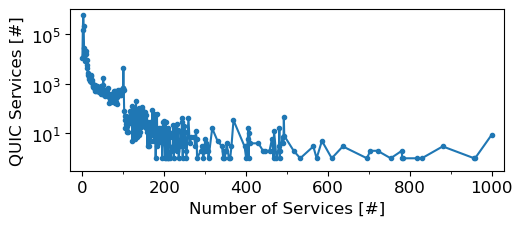

In [4]:
ax = df_tls[df_tls["type"]=="LEAF"][
        "sancount"].value_counts().sort_index().plot(
            logy=True, marker=".", figsize=(8*0.7,3*0.7))

ax.set_xlabel("Number of Services [#]")
ax.set_ylabel("QUIC Services [#]")
ax.set_xlim((-30,1030))
ax.set_ylim((10**-0.5,10**6))
ax.xaxis.set_minor_locator(MultipleLocator(100))

fig = ax.get_figure()
plt.show()
plt.close(fig)

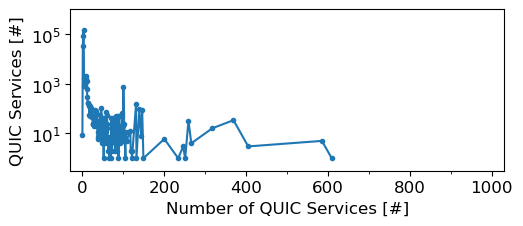

In [5]:
df_tls_quicservices = df_tls[ (df_tls["domain"].isin(set(df_quic["domain"]))) ]

ax = df_tls_quicservices[df_tls_quicservices["type"]=="LEAF"][#.drop_duplicates(subset="hash")[
        "sancount"].value_counts().sort_index().plot(
            logy=True, marker=".", figsize=(8*0.7,3*0.7))

ax.set_xlabel("Number of QUIC Services [#]")
ax.set_ylabel("QUIC Services [#]")
ax.set_xlim((-30,1030))
ax.set_ylim((10**-0.5,10**6))
ax.xaxis.set_minor_locator(MultipleLocator(100))

fig = ax.get_figure()
plt.show()
plt.close(fig)

# Detect Cruise-Liner Certs

In [6]:
# todo discuss if we should drop duplicates here!
df_cruisers = df_tls_quicservices[df_tls_quicservices["type"]=="LEAF"].drop_duplicates(
                subset=["hash"])[["hash","isscn","sansize","sancount","certsize_total","certsize"]].copy()

df_cruisers = df_tls_quicservices[df_tls_quicservices["type"]=="LEAF"][
    ["hash","isscn","sansize","sancount","certsize_total","certsize"]].copy()

df_cruisers["sansize_share"] = df_cruisers["sansize"]/df_cruisers["certsize"]*100

Total Leaf Certs: 272283
Max: {'certsize': 15227.0, 'sansize_share': 90.29355749655218}
Cruiser Certs (28.9 % SANs): 2752
Percentile: 1.0107131183364366
Affected QUIC Domains from our list:  2748 / 272256


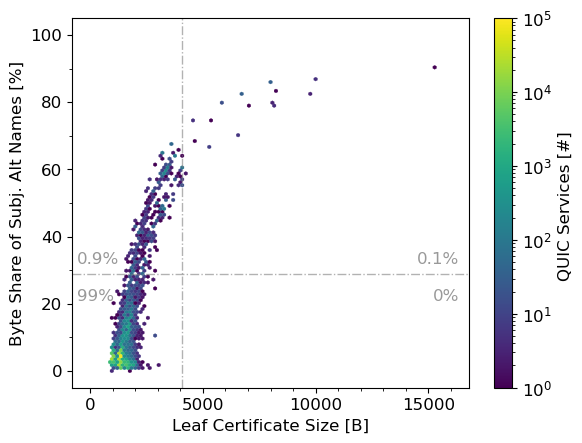

In [7]:
ax = df_cruisers.plot.hexbin(x="certsize", y="sansize_share",
                        sharex=False, norm=mpc.LogNorm(vmin=10**0, vmax=10**5,), 
                        cmap=["Spectral_r","viridis","icefire","coolwarm","crest","flare", "cividis"][1],
                        reduce_C_function=np.size, alpha=1,
                        linewidths=0.2,
                        extent=(0,16000,0,100))

cruiser_threshold =  28.9 # 16.2 ||| ### 6.5 for 1%  ### 32.98 for 0.1%
ampl_threshold = 3*1357
ax.axhline(cruiser_threshold, linestyle="-.", linewidth=1., color="grey", alpha=0.6)
ax.axvline(ampl_threshold, linestyle="-.", linewidth=1., color="grey", alpha=0.6)

df_cruiser_found = df_cruisers[df_cruisers["sansize_share"]>cruiser_threshold]

print("Total Leaf Certs:", len(df_cruisers),)
print("Max:", df_cruisers[["certsize","sansize_share"]].max().to_dict())

print(f"Cruiser Certs ({cruiser_threshold} % SANs):", len(df_cruiser_found))
print("Percentile:", len(df_cruiser_found)/len(df_cruisers)*100)
print("Affected QUIC Domains from our list: ", df_tls_quicservices[df_tls_quicservices["hash"].isin(
    df_cruiser_found["hash"])]["domain"].nunique(), "/", df_quic["domain"].nunique())

# labels
ax.set_xlabel("Leaf Certificate Size [B]")
ax.set_ylabel(f"Byte Share of Subj. Alt Names [%]")
plt.gcf().get_axes()[1].set_ylabel("QUIC Services [#] ")
ax.xaxis.set_minor_locator(MultipleLocator(1000))
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.text(-600, 21, "99%", color="grey", alpha=0.8)
ax.text(-600, 32, "0.9%", color="grey", alpha=0.8)
ax.text(14500, 32, "0.1%", color="grey", alpha=0.8)
ax.text(15200, 21, "0%", color="grey", alpha=0.8)

fig = ax.get_figure()
fig.savefig(f"./plots/hexbin_quic_certs_cruiser.pdf", bbox_inches='tight')
fig.savefig(f"./plots/hexbin_quic_certs_cruiser.png", bbox_inches='tight', dpi=200)
plt.show()
plt.close(fig)

In [8]:
# lets find out how many services in each area of the hexbin
(df_cruisers.groupby([ list( zip( 
                        (df_cruisers["sansize_share"]>cruiser_threshold), 
                        (df_cruisers["certsize"]>ampl_threshold))) ]).size() / \
                            len(df_cruisers) * 100).round(1)

(False, False)    99.0
(True, False)      0.9
(True, True)       0.1
dtype: float64

### Who is issuing cruise-liner certs?

In [9]:
df_cruisers[ (df_cruisers["sansize_share"]>cruiser_threshold) ]["isscn"].value_counts(
    normalize=True).to_frame()*100

,isscn
GTS CA 1D4,30.886628
R3,17.223837
GTS CA 1C3,14.171512
DigiCert TLS RSA SHA256 2020 CA1,5.886628
GlobalSign Atlas R3 DV TLS CA 2022 Q1,4.869186
GlobalSign RSA OV SSL CA 2018,4.142442
GlobalSign Atlas R3 DV TLS CA 2022 Q2,4.106105
Sectigo RSA Organization Validation Secure Server CA,3.197674
GlobalSign Atlas R3 DV TLS CA 2022 Q3,2.507267
Amazon,2.361919
